# Optimization Goal
We’ll model a simplified mode allocation optimization:
- **Minimize expected delays** while distributing shipments across available transport modes, constrained by mode capacities.

In [ ]:
 
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpStatus
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(r"C:\Users\Yogesh Verma\Desktop\Educational Content\intern project\task4\Train.csv")  # Ensure this path is correct

# Step 1: Calculate delay probabilities for each mode
delay_prob_by_mode = df.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean().to_dict()

# Step 2: Define mode capacities (assumed)
mode_capacity = {'Flight': 300, 'Road': 400, 'Ship': 200}

# Step 3: Sample data for fast computation
df_sample = df.sample(500, random_state=42).reset_index(drop=True)
modes = ['Flight', 'Road', 'Ship']

In [3]:
# Step 4: Define optimization problem
model = LpProblem("Shipment_Mode_Optimization", LpMinimize)

# Step 5: Create binary decision variables
x = {
    (i, m): LpVariable(f"x_{i}_{m}", cat=LpBinary)
    for i in df_sample.index
    for m in modes
}

# Step 6: Objective function: minimize expected delay
model += lpSum(
    x[i, m] * delay_prob_by_mode[m]
    for i in df_sample.index for m in modes
)

In [4]:
# Step 7: Constraints - one mode per shipment
for i in df_sample.index:
    model += lpSum(x[i, m] for m in modes) == 1

# Step 8: Mode capacity constraints
for m in modes:
    model += lpSum(x[i, m] for i in df_sample.index) <= mode_capacity[m]

# Step 9: Solve
model.solve()


1

In [5]:
# Step 10: Retrieve optimized mode for each shipment
assignments = []
for i in df_sample.index:
    for m in modes:
        if x[i, m].value() == 1:
            assignments.append((i, m))

# Step 11: Prepare results DataFrame
df_results = df_sample.copy()
df_results['Optimized_Mode'] = [m for _, m in sorted(assignments)]

# Step 12: Calculate expected delays before & after
original_delay = df_results['Mode_of_Shipment'].map(delay_prob_by_mode).sum()
optimized_delay = df_results['Optimized_Mode'].map(delay_prob_by_mode).sum()
improvement_percent = 100 * (original_delay - optimized_delay) / original_delay

C:\Users\Yogesh Verma\AppData\Local\Temp\ipykernel_21892\2919385968.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Mode_of_Shipment', data=df_results, palette='Set2')
C:\Users\Yogesh Verma\AppData\Local\Temp\ipykernel_21892\2919385968.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Optimized_Mode', data=df_results, palette='Set1')


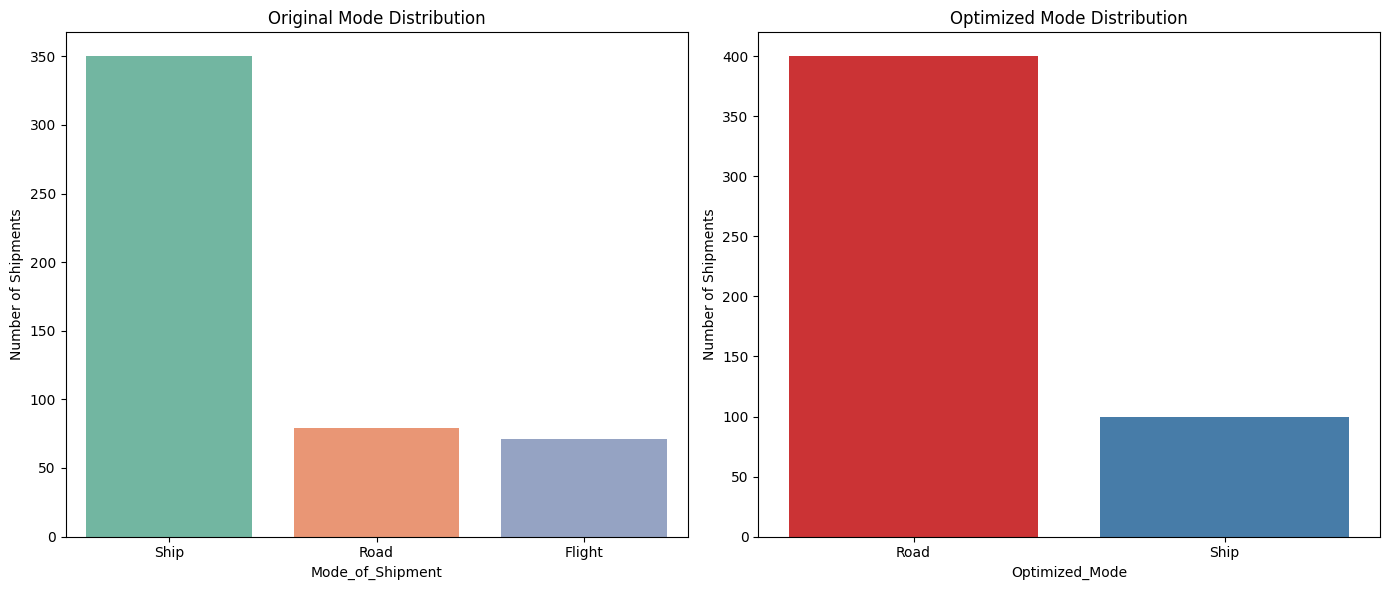

In [6]:
# Step 13: Visualize original vs optimized mode distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Mode_of_Shipment', data=df_results, palette='Set2')
plt.title("Original Mode Distribution")
plt.ylabel("Number of Shipments")

plt.subplot(1, 2, 2)
sns.countplot(x='Optimized_Mode', data=df_results, palette='Set1')
plt.title("Optimized Mode Distribution")
plt.ylabel("Number of Shipments")
plt.tight_layout()
plt.show()

In [7]:
# Step 14: Business insights summary
print("\n📊 Business Recommendation Summary:")
print(f"Original Total Expected Delay     : {original_delay:.2f}")
print(f"Optimized Total Expected Delay    : {optimized_delay:.2f}")
print(f"Improvement in Expected Delays    : {improvement_percent:.2f}%")
print(f"Mode capacity used (assumed)      : {mode_capacity}")


📊 Business Recommendation Summary:
Original Total Expected Delay     : 298.32
Optimized Total Expected Delay    : 294.98
Improvement in Expected Delays    : 1.12%
Mode capacity used (assumed)      : {'Flight': 300, 'Road': 400, 'Ship': 200}
